<a href="https://colab.research.google.com/github/gu1lleom/Colab-Clases/blob/main/DM_Clase_06_Ingenier%C3%ADa_de_atributos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingeniería de atributos

Datos en https://www.kaggle.com/code/aeryan/spotify-music-analysis/data


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/data.csv', index_col=0)
df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


## Normalización, estandarización

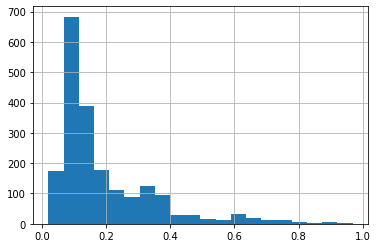

In [ ]:
df["liveness"].hist(bins=20);

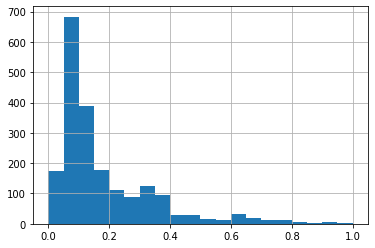

In [ ]:
df_min_max = (df["liveness"] - df["liveness"].min()) / (df["liveness"].max() - df["liveness"].min())
df_min_max.hist(bins=20);

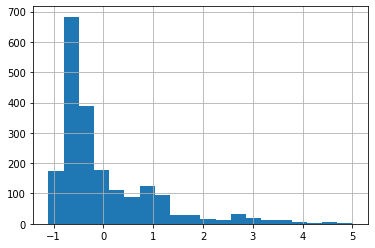

In [ ]:
df_est = (df["liveness"] - df["liveness"].mean()) / df["liveness"].std()
df_est.hist(bins=20);

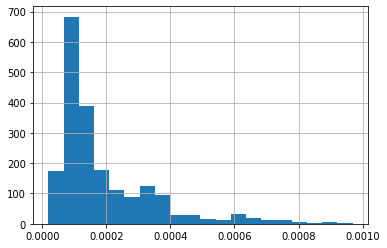

In [ ]:
df_de = (df["liveness"] / 10**3)
df_de.hist(bins=20);

## Transformaciones

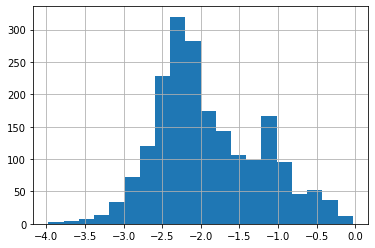

In [ ]:
df_log = np.log(df["liveness"])
df_log.hist(bins=20);

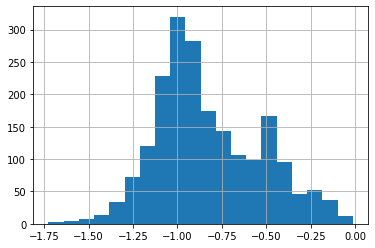

In [ ]:
df_log10 = np.log10(df["liveness"])
df_log10.hist(bins=20);

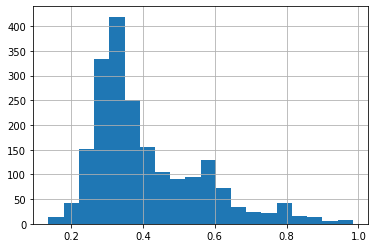

In [ ]:
df_sqrt = np.sqrt(df["liveness"])
df_sqrt.hist(bins=20);

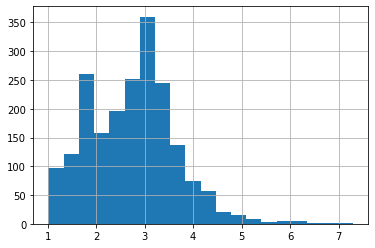

In [ ]:
df_1_sqrt = 1.0 / np.sqrt(df["liveness"])
df_1_sqrt.hist(bins=20);

 # Transformaciones

## Binning 

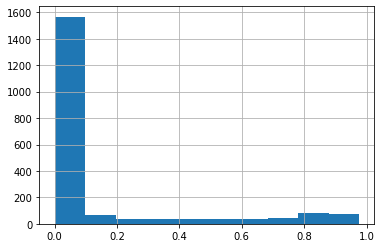

In [ ]:
df["instrumentalness"].hist();

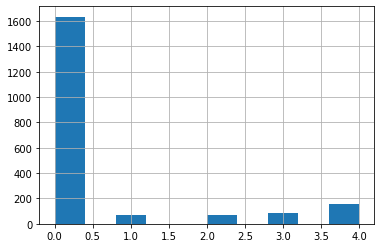

In [ ]:
pd.cut(df["instrumentalness"], bins=5, labels=False).hist();

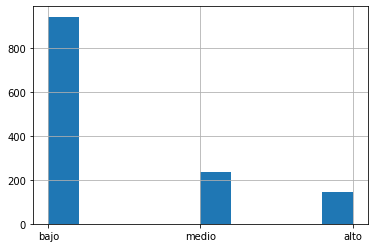

In [ ]:
pd.cut(df["instrumentalness"], bins=(0.0, 0.2, 0.8, 1.0), labels=["bajo", "medio", "alto"]).hist();

In [ ]:
df["instrumentalness"].rank(method="min").sort_values()

1008       1.0
481        1.0
966        1.0
1129       1.0
1487       1.0
         ...  
725     2013.0
1619    2014.0
1575    2015.0
271     2016.0
1313    2017.0
Name: instrumentalness, Length: 2017, dtype: float64

## Discretización basada en Entropia

In [ ]:
df["target"].value_counts()

1    1020
0     997
Name: target, dtype: int64

In [ ]:
c0 = df["target"]
pcts = np.bincount(c0) / len(c0)
entropia0 = -np.sum([p * np.log2(p) for p in pcts if p > 0])
entropia0

0.999906201081461

In [ ]:
c1 = df.loc[df["instrumentalness"] > 0.8, "target"]
pcts = np.bincount(c1) / len(c1)
entropia1 = -np.sum([p * np.log2(p) for p in pcts if p > 0])
entropia1

0.9505668528932195

In [ ]:
c2 = df.loc[df["instrumentalness"] <= 0.8, "target"]
pcts = np.bincount(c2) / len(c2)
entropia2 = -np.sum([p * np.log2(p) for p in pcts if p > 0])
entropia2

0.9999536356539305

In [ ]:
information_gain = entropia0 - sum((np.bincount(c0) / len(c0)) * (entropia1, entropia2))
information_gain

0.024364376241823527

## Peso de la evidencia

In [ ]:
bins = pd.cut(df["instrumentalness"], bins=10,  duplicates='drop', labels=False)
df2 = pd.DataFrame({'bins': bins, 'target': df["target"]})
df3 =  df2.groupby('bins', as_index=False).agg({"target": ["count", "sum"]})
df3.columns = ['bin', 'n', 'events']
df3['non_events'] = df3['n'] - df3['events']
df3["pct_events"] = df3['events'] / df3['events'].sum()
df3["pct_non_events"] = df3['non_events'] / df3['non_events'].sum()

df3["WoE"] = np.log(df3['pct_events'] / df3['pct_non_events'])
df3

,bin,n,events,non_events,pct_events,pct_non_events,WoE
0,0,1567,723,844,0.708824,0.846540,-0.177550
1,1,68,38,30,0.037255,0.030090,0.213582
2,2,35,26,9,0.025490,0.009027,1.038065
3,3,34,25,9,0.024510,0.009027,0.998844
4,4,36,24,12,0.023529,0.012036,0.670340
5,5,33,25,8,0.024510,0.008024,1.116627
6,6,40,26,14,0.025490,0.014042,0.596232
7,7,46,33,13,0.032353,0.013039,0.908751
8,8,82,53,29,0.051961,0.029087,0.580189
9,9,76,47,29,0.046078,0.029087,0.460045


In [ ]:
m = dict(zip(df3["bin"], df3["WoE"]))
m

{0: -0.17755040875367079,
 1: 0.21358164174775202,
 2: 1.0380648243687842,
 3: 0.9988441112155029,
 4: 0.6703400442434669,
 5: 1.1166271468718865,
 6: 0.5962320720897449,
 7: 0.9087510676884651,
 8: 0.5801889472491695,
 9: 0.4600446354071062}

In [ ]:
df["instrumentalness"] = pd.cut(df["instrumentalness"], bins=10,  duplicates='drop', labels=False)
df["instrumentalness"]

0       0
1       0
2       0
3       5
4       5
       ..
2012    0
2013    0
2014    0
2015    6
2016    0
Name: instrumentalness, Length: 2017, dtype: int64

In [ ]:
df["instrumentalness"] = df["instrumentalness"].map(m)
df["instrumentalness"]

0      -0.177550
1      -0.177550
2      -0.177550
3       1.116627
4       1.116627
          ...   
2012   -0.177550
2013   -0.177550
2014   -0.177550
2015    0.596232
2016   -0.177550
Name: instrumentalness, Length: 2017, dtype: float64